# Application for the role of Senior Data Engineer 
## Job Ref - 025-AC603-0721

### Jose Mendoza Application ID: 81864553
25 - Aug - 2021

# 0. Import required modules 

In [171]:
# 1. Data extract

import json
import requests

# 2. Database manipulation

import sqlite3
from sqlite3 import Error

# 3. Data analysis

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np


# 1. Retrieve server data in JSON format

### Convert json file into a python object "dataobj"

In [133]:
# Use requests to issue a standard HTTP GET request

url = "http://open.statswales.gov.wales/en-gb/dataset/hlth0091"
result = requests.get(url)

# Use the built-in JSON function to return parsed data

dataobj = result.json()

### 1.1 Data stored under the nested json within the 'value' key

In [135]:
# Explore first row in dataframe:

print('Column names: ', dataobj['value'][0].keys())
print('\n')
print('Values : ', dataobj['value'][0].values())


Column names:  dict_keys(['Data', 'Date_Code', 'Date_ItemName_ENG', 'Date_SortOrder', 'Date_ItemNotes_ENG', 'LocalHealthBoard_Code', 'LocalHealthBoard_ItemName_ENG', 'LocalHealthBoard_SortOrder', 'LocalHealthBoard_Hierarchy', 'LocalHealthBoard_ItemNotes_ENG', 'LocalHealthBoard_AltCode1', 'Hospitaltype_Code', 'Hospitaltype_ItemName_ENG', 'Hospitaltype_SortOrder', 'Hospitaltype_Hierarchy', 'Hospitaltype_ItemNotes_ENG', 'Indicator_Code', 'Indicator_ItemName_ENG', 'Indicator_SortOrder', 'Indicator_Hierarchy', 'Indicator_ItemNotes_ENG', 'RowKey', 'PartitionKey'])


Values :  dict_values(['28.00000000', '20200401', '1 Apr 2020', '10', '', '7A1', 'Betsi Cadwaladr University Local Health Board', '2', 'W92000004', '', 'W11000023', 'NHS', 'All NHS hospitals', '1', 'AllHosp', 'Includes data from acute hospitals only until 19 April 2020. Field hospitals data were added from 20 April 2020, community hospitals data were added from 23 April 2020, and mental health hospitals data were added from 10 Ju

### 1.2 Prepare function to feed data entries into SQL stream for sqlite3 submission:

In [312]:
# Test function to be implemented later in the code

def QueryBuilder(_dict):
    
    '''
    Given a data entry in the for of python dictionary, returns the corresponding SQL query to store these values in a sqlite3 database.
    
    Args:
        dataobject: Python dictionary
        
    Returns:
        query: SQL string for data entry insert
    
    '''

    # Concatenate both column and value items with commas:
    column_string = ' '.join([("\"" + column + "\",") for column in _dict.keys() ])[:-1]
    value_string = ' '.join([("\"" + value + "\",") for value in _dict.values() ])[:-1]
    
    query = 'INSERT INTO ' + column_string + ' VALUES ' + value_string
    
      
    return query

Test the function with a sample row:

In [138]:
print(QueryBuilder(dataobj['value'][5]))

INSERT INTO "Data", "Date_Code", "Date_ItemName_ENG", "Date_SortOrder", "Date_ItemNotes_ENG", "LocalHealthBoard_Code", "LocalHealthBoard_ItemName_ENG", "LocalHealthBoard_SortOrder", "LocalHealthBoard_Hierarchy", "LocalHealthBoard_ItemNotes_ENG", "LocalHealthBoard_AltCode1", "Hospitaltype_Code", "Hospitaltype_ItemName_ENG", "Hospitaltype_SortOrder", "Hospitaltype_Hierarchy", "Hospitaltype_ItemNotes_ENG", "Indicator_Code", "Indicator_ItemName_ENG", "Indicator_SortOrder", "Indicator_Hierarchy", "Indicator_ItemNotes_ENG", "RowKey", "PartitionKey" VALUES "768.00000000", "20200401", "1 Apr 2020", "10", "", "7A1", "Betsi Cadwaladr University Local Health Board", "2", "W92000004", "", "W11000023", "TotAcute", "All Acute hospitals", "2", "NHS", "Prior to 10 July 2020, data may include small numbers of mental health unit beds.", "CO_Hosps_All", "All hospitalisations", "104", "", "", "0000000000000005", ""


# 2. Build sqlite3 database

### 2.1 Function to create a sqlite database
Define a connection function to generate a .db sqlite3 database file in the working directory

In [139]:
def CreateConnection(db_file):
    
    '''
    create a database connection to a SQLite database
    
    '''
    
    conn = None
    
    try:
        
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
        
    except Error as e:
        
        print(e)
        
    finally:
        
        if conn:
            conn.close()

        
    return None

### 2.2 Function to create a table compatible with the provided json dataset
Create a SQL table within the sqlite database created above.
Use the first data row from the json file to set up column names and data types.

In [140]:
def TableBuilder(_dict, table_name, primary_key):
    
    '''
    Given a Python dictionary, returns a SQL query to build a sqlite database compatible with the aforementioned dictionary.
    
    Args:
    
        _dict: Python dictionary containing data we wish to store.
        primary_key: Name of the dictionary key to be used as primary key in the resulting table.
        
    Returns:
    
        query: String containing a SQL query to create the above table.
    
    '''
    
    
    def GuessType(value, max_length = 25):
    
        '''

        Nested function
        Given a raw value, finds the most appropiate datatype to be stored in a SQL table.

        Args:

            value: Python variable to be evaluated.
            max_length: Length criteria to decide between TEXT or BLOG string type. Default is 25 characters.

        Returns:

            String corresponding to the selected SQL data type.

        '''
        try:
            value = int(value)
            return 'INTEGER'

        except:

            try:
                value = float(value)
                return 'REAL'

            except:

                if len(value) > max_length:
                    return 'BLOB'

                else:
                    return 'TEXT'
    
    
    column_block = ''
     
    for column, value in list(zip(_dict.keys(), _dict.values())):
        
        IfPrimary = lambda x: " NOT NULL UNIQUE PRIMARY KEY" if (column == primary_key) else ""
        column_block += "\"" + column + "\"    "  + GuessType(value) + IfPrimary(column) + ','
    
    
    query = '''
    CREATE TABLE "{table_name}"(
    
    {column_block}     

    );
    
    '''.format(table_name = table_name, column_block = column_block[:-1])
    
    
    return query
    

Test the function:

### 2.3 Use the above functions to: 
   #### 2.3.1 Create a sqlite3 database, 


In [157]:
# Create database:

db_filepath = r"nhs_covid_test.db"

CreateConnection(db_filepath)

2.6.0



   #### 2.3.2 Establish a python connection

In [142]:
# Establish a python connection:

with sqlite3.connect(db_filepath) as db:
        cursor = db.cursor()

   #### 2.3.3 Create a table, 

In [150]:
# Create a table:

table_name = 'COVID_DATA'
primary_key = 'RowKey'
table_query = TableBuilder(dataobj['value'][0], table_name, primary_key)

cursor.execute(table_query)

db.commit()


### 2.4 Prepare a function to feed data entries into a SQL stream for sqlite3 submission:

In [154]:
def ExecuteSqlInsert(dataobj, table_name, cursor):
    
    '''
    Given a data object containing data in the form of a list of dictionaries, executes an INSERT SQL query against a target database.
    
    Args:
    
        df: Pandas dataframe containing the desired data.
        cursor: sqlite3 cursor object already configured against the target database.
    
    '''

    def QueryBuilder(_dict, table_name):
    
        '''
        Builds an INSERT INTO SQL query from data stored as a python dictionary.
        
        Args:
        
            _dict: Python dictionary

        Returns:
        
            query: SQL string for data entry insert
            

        '''

        # Concatenate both column and value items with commas:
        column_string = ' '.join([("\"" + column + "\",") for column in _dict.keys() ])[:-1]
        value_string = ' '.join([("\"" + value + "\",") for value in _dict.values() ])[:-1]

        query = 'INSERT INTO ' + table_name + "(" + column_string + ') VALUES (' + value_string + ' )'


        return query
    
    

    for _dict in dataobj:
        
        query = QueryBuilder(_dict, table_name)
    
        cursor.execute(query)
        
    
    db.commit()
    
    return None

Test the function:

# 3. Retrieve information via SQL for Data Analysis
Perform exploratory data analysis, visualizations and getting insight from the data

In [158]:
# Use the existing connection to retrieve the data back into a pandas dataframe:

df = pd.read_sql_query("SELECT * from COVID_DATA", db)


Close database connection after having imported dataframe:

In [162]:
db.close()

### 3.1 Explore first rows of the dataframe

In [159]:
df.head(10)

,Data,Date_Code,Date_ItemName_ENG,Date_SortOrder,Date_ItemNotes_ENG,LocalHealthBoard_Code,LocalHealthBoard_ItemName_ENG,LocalHealthBoard_SortOrder,LocalHealthBoard_Hierarchy,LocalHealthBoard_ItemNotes_ENG,...,Hospitaltype_SortOrder,Hospitaltype_Hierarchy,Hospitaltype_ItemNotes_ENG,Indicator_Code,Indicator_ItemName_ENG,Indicator_SortOrder,Indicator_Hierarchy,Indicator_ItemNotes_ENG,RowKey,PartitionKey
0,28.0,20200401,1 Apr 2020,10,,7A1,Betsi Cadwaladr University Local Health Board,2,W92000004,,...,1,AllHosp,Includes data from acute hospitals only until ...,CO_Admissions_C19,COVID-19 admissions (suspected and confirmed),102,Misc_Admissions_All,Patients admitted as suspected or confirmed wi...,0,
1,28.0,20200401,1 Apr 2020,10,,7A1,Betsi Cadwaladr University Local Health Board,2,W92000004,,...,2,NHS,"Prior to 10 July 2020, data may include small ...",CO_Admissions_C19,COVID-19 admissions (suspected and confirmed),102,Misc_Admissions_All,Patients admitted as suspected or confirmed wi...,1,
2,98.0,20200401,1 Apr 2020,10,,7A1,Betsi Cadwaladr University Local Health Board,2,W92000004,,...,1,AllHosp,Includes data from acute hospitals only until ...,CO_Admissions_NonC19,Non-COVID-19 admissions&#10;,103,Misc_Admissions_All,,2,
3,98.0,20200401,1 Apr 2020,10,,7A1,Betsi Cadwaladr University Local Health Board,2,W92000004,,...,2,NHS,"Prior to 10 July 2020, data may include small ...",CO_Admissions_NonC19,Non-COVID-19 admissions&#10;,103,Misc_Admissions_All,,3,
4,768.0,20200401,1 Apr 2020,10,,7A1,Betsi Cadwaladr University Local Health Board,2,W92000004,,...,1,AllHosp,Includes data from acute hospitals only until ...,CO_Hosps_All,All hospitalisations,104,,,4,
5,768.0,20200401,1 Apr 2020,10,,7A1,Betsi Cadwaladr University Local Health Board,2,W92000004,,...,2,NHS,"Prior to 10 July 2020, data may include small ...",CO_Hosps_All,All hospitalisations,104,,,5,
6,107.0,20200401,1 Apr 2020,10,,7A1,Betsi Cadwaladr University Local Health Board,2,W92000004,,...,1,AllHosp,Includes data from acute hospitals only until ...,CO_Hosps_C19,Hospitalisations for COVID-19&#10;,105,CO_Hosps_All,People in hospital for COVID-19 related reason...,6,
7,107.0,20200401,1 Apr 2020,10,,7A1,Betsi Cadwaladr University Local Health Board,2,W92000004,,...,2,NHS,"Prior to 10 July 2020, data may include small ...",CO_Hosps_C19,Hospitalisations for COVID-19&#10;,105,CO_Hosps_All,People in hospital for COVID-19 related reason...,7,
8,29.0,20200401,1 Apr 2020,10,,7A1,Betsi Cadwaladr University Local Health Board,2,W92000004,,...,1,AllHosp,Includes data from acute hospitals only until ...,CO_Hosps_C19_Con,Hospitalisations for COVID-19 - confirmed&#10;,106,CO_Hosps_C19,Confirmed COVID-19 patients are patients who h...,8,
9,29.0,20200401,1 Apr 2020,10,,7A1,Betsi Cadwaladr University Local Health Board,2,W92000004,,...,2,NHS,"Prior to 10 July 2020, data may include small ...",CO_Hosps_C19_Con,Hospitalisations for COVID-19 - confirmed&#10;,106,CO_Hosps_C19,Confirmed COVID-19 patients are patients who h...,9,


In [313]:
# Explore dataframe size:

print('Datframe length: ', len(df))

Datframe length:  1000


In [226]:
# Column exploration:

for column in df.columns:
    
    print('\nColumn :', column, ' Value counts:\n', df[column].value_counts())


Column : Data  Value counts:
 0.0       26
7.0       16
55.0      14
27.0      12
52.0      12
          ..
112.0      2
700.0      2
393.0      2
193.0      2
3502.0     2
Name: Data, Length: 282, dtype: int64

Column : Date_Code  Value counts:
 20200407    128
20200406    128
20200405    128
20200404    128
20200403    128
20200402    128
20200401    128
20200408    104
Name: Date_Code, dtype: int64

Column : Date_ItemName_ENG  Value counts:
 5 Apr 2020    128
1 Apr 2020    128
3 Apr 2020    128
4 Apr 2020    128
2 Apr 2020    128
7 Apr 2020    128
6 Apr 2020    128
8 Apr 2020    104
Name: Date_ItemName_ENG, dtype: int64

Column : Date_SortOrder  Value counts:
 16    128
15    128
14    128
13    128
12    128
11    128
10    128
17    104
Name: Date_SortOrder, dtype: int64

Column : Date_ItemNotes_ENG  Value counts:
     1000
Name: Date_ItemNotes_ENG, dtype: int64

Column : LocalHealthBoard_Code  Value counts:
 7A4          128
7A1          128
7A5          128
7A3          128
7A6

### 3.2 Apply filters to explore covid data

In [314]:
indicator_names = df['Indicator_ItemName_ENG'].unique()

indicator_names

array(['COVID-19 admissions (suspected and confirmed)',
       'Non-COVID-19 admissions&#10;', 'All hospitalisations',
       'Hospitalisations for COVID-19&#10;',
       'Hospitalisations for COVID-19 - confirmed&#10;',
       'Hospitalisations for COVID-19 - suspected&#10;', 'All admissions',
       'Non-COVID-19 hospitalisations&#10;'], dtype=object)

In [166]:
covid_indicators = ['COVID-19 admissions (suspected and confirmed)',
       'Hospitalisations for COVID-19&#10;',
       'Hospitalisations for COVID-19 - confirmed&#10;',
       'Hospitalisations for COVID-19 - suspected&#10;']


In [167]:
df_covid = df[df['Indicator_ItemName_ENG'].isin(covid_indicators)]

df_covid['Indicator_ItemName_ENG'].unique()

array(['COVID-19 admissions (suspected and confirmed)',
       'Hospitalisations for COVID-19&#10;',
       'Hospitalisations for COVID-19 - confirmed&#10;',
       'Hospitalisations for COVID-19 - suspected&#10;'], dtype=object)

In [168]:
len(df_covid)

500

### 3.3 Case distribution by Health Board

Set up seaborn graphic conditions

In [ ]:
# Set color palette

sns.set_palette('Set1')

# Set style

sns.set_style('darkgrid')
sns.set(font_scale=2)

Number of cases by Health Board:

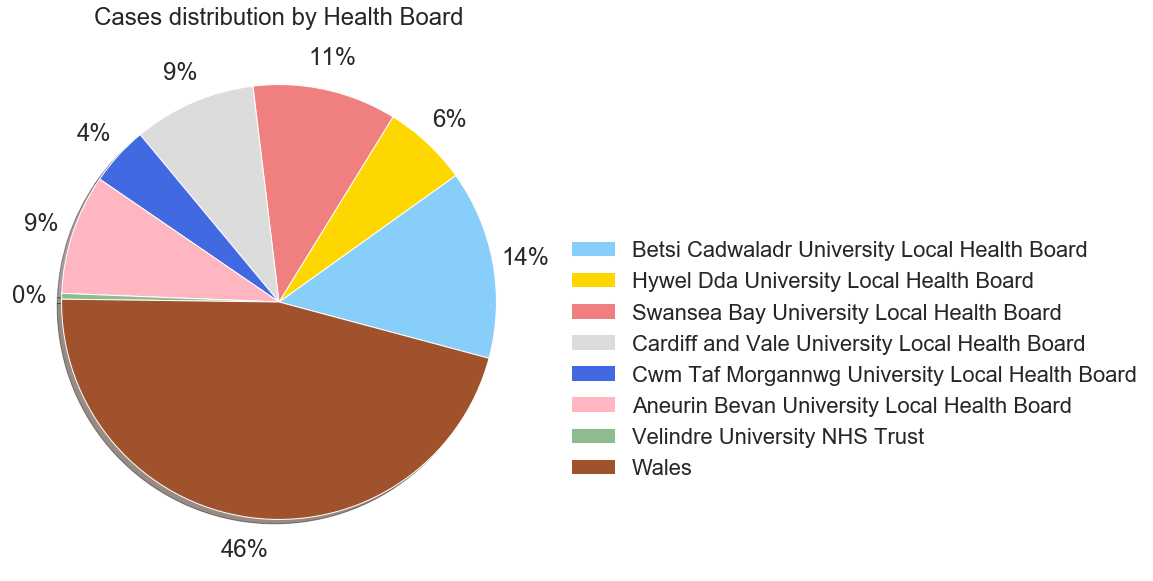

In [302]:
# Pie Chart: League of Legends Viewers' Whereabouts

plt.figure(figsize = (10, 10))

labels = list(df_covid['LocalHealthBoard_ItemName_ENG'].unique())

cases_by_board = df_covid.groupby('LocalHealthBoard_ItemName_ENG')['Data'].sum()

colors = ['lightskyblue', 'gold', 'lightcoral', 'gainsboro', 'royalblue', 'lightpink', 'darkseagreen', 'sienna', 'khaki', 'gold', 'violet', 'yellowgreen']


plt.pie(cases_by_board, colors=colors, shadow=True, startangle=345, autopct='%1.0f%%', pctdistance=1.15)

plt.title("Cases distribution by Health Board")
plt.legend(labels, loc="best", bbox_to_anchor=(1, 0.65), frameon = False)

plt.show()

### 3.3 Data distribution

C:\Users\Jose Carlos\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


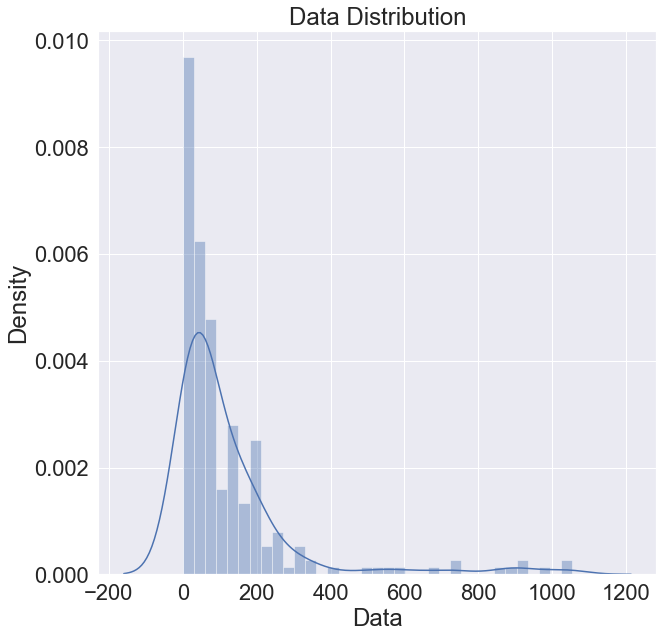

In [300]:
plt.figure(figsize = (10, 10))

sns.distplot(df_covid.Data)
plt.title('Data Distribution')

plt.show()

As the data is highly skewed to right hand sinde, apply a logaritmic transformation for normalisation:

C:\Users\Jose Carlos\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


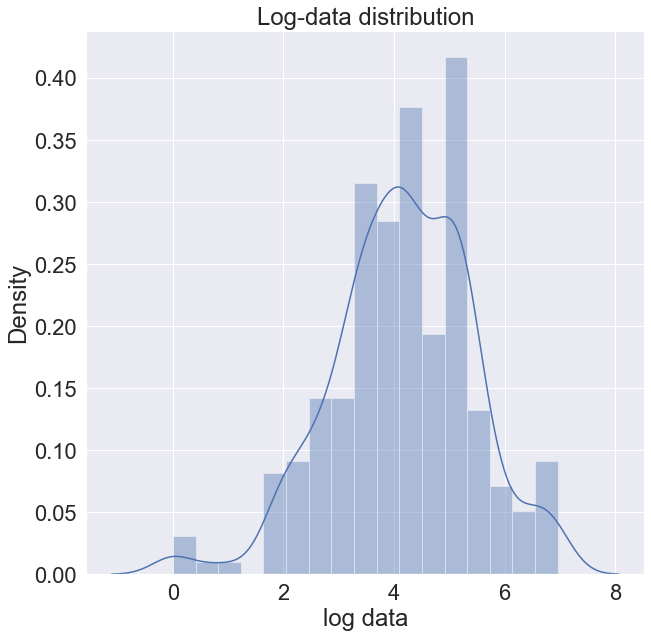

In [301]:
plt.figure(figsize = (10, 10))

log_data = df_covid.Data[df_covid.Data>0]
log_data = np.log(log_data)

sns.distplot(log_data)
plt.xlabel('log data')

plt.title('Log-data distribution')


plt.show()

### 3.4 Evolution over time:

In [197]:
df_covid['Date_ItemName_ENG'].unique()

array(['1 Apr 2020', '2 Apr 2020', '3 Apr 2020', '4 Apr 2020',
       '5 Apr 2020', '6 Apr 2020', '7 Apr 2020', '8 Apr 2020'],
      dtype=object)

Dataset covers a single week of case recordings 

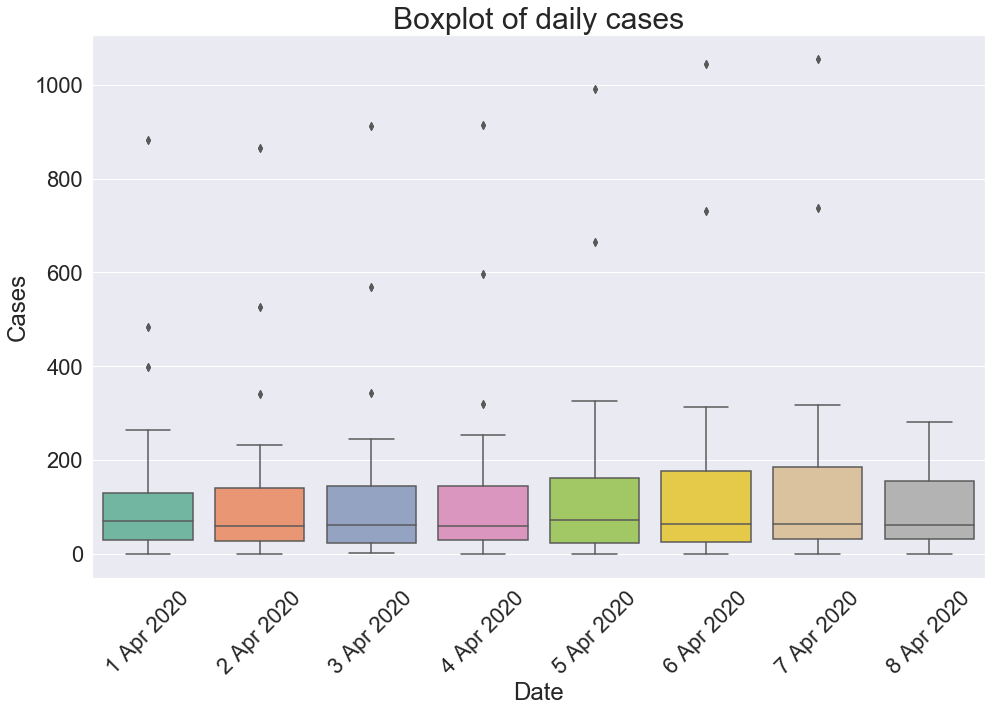

In [306]:
# Explore outliers by the use of boxplots:

plt.figure(figsize=(16, 10))

sns.set_palette('Set2')

sns.boxplot(data = df_covid, x="Date_ItemName_ENG", y="Data")

plt.title('Boxplot of daily cases', fontdict = {'fontsize' : 30})
plt.xlabel('Date')
plt.ylabel('Cases')

plt.xticks(rotation=45) 

plt.show()

In [214]:
# Explore grouping by board:

df_covid_boards = df_covid.groupby('LocalHealthBoard_ItemName_ENG').mean()['Data']

df_covid_boards.head()

LocalHealthBoard_ItemName_ENG
Aneurin Bevan University Local Health Board        137.03125
Betsi Cadwaladr University Local Health Board       61.68750
Cardiff and Vale University Local Health Board     104.34375
Cwm Taf Morgannwg University Local Health Board     88.78125
Hywel Dda University Local Health Board             43.09375
Name: Data, dtype: float64

In [291]:
df_covid_date = df_covid.groupby(['LocalHealthBoard_ItemName_ENG', 'Date_ItemName_ENG']).sum()['Data'].reset_index()

df_covid_date

,LocalHealthBoard_ItemName_ENG,Date_ItemName_ENG,Data
0,Aneurin Bevan University Local Health Board,1 Apr 2020,1204.0
1,Aneurin Bevan University Local Health Board,2 Apr 2020,986.0
2,Aneurin Bevan University Local Health Board,3 Apr 2020,1038.0
3,Aneurin Bevan University Local Health Board,4 Apr 2020,1034.0
4,Aneurin Bevan University Local Health Board,5 Apr 2020,1128.0
...,...,...,...
58,Wales,3 Apr 2020,3864.0
59,Wales,4 Apr 2020,3928.0
60,Wales,5 Apr 2020,4228.0
61,Wales,6 Apr 2020,4422.0


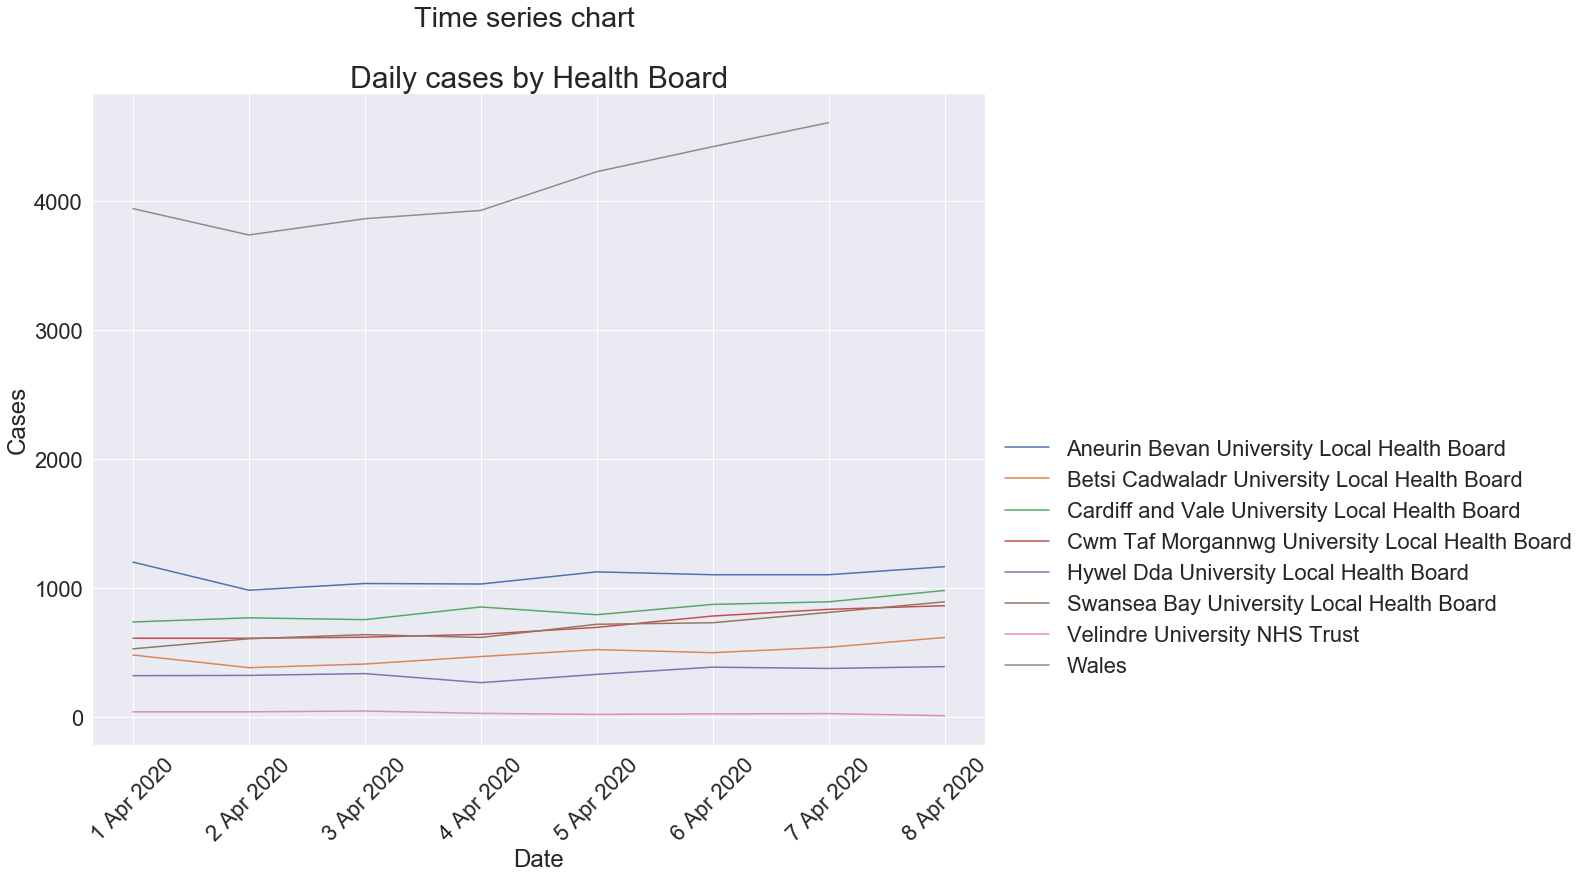

In [311]:
# Time series chart

plt.figure(figsize=(16, 12))

for board in list(df_covid_date['LocalHealthBoard_ItemName_ENG'].unique()):
    
    y = df_covid_date[df_covid_date['LocalHealthBoard_ItemName_ENG'] == board]['Data']
    x = df_covid_date[df_covid_date['LocalHealthBoard_ItemName_ENG'] == board]['Date_ItemName_ENG']
    
    plt.plot(x, y)
    

sns.set(font_scale=2)

plt.suptitle('Time series chart', fontdict = {'fontsize' : 80})
plt.title('Daily cases by Health Board', fontdict = {'fontsize' : 30})
plt.xlabel('Date')
plt.ylabel('Cases')

plt.xticks(rotation=45)    
plt.legend(list(df_covid_date['LocalHealthBoard_ItemName_ENG'].unique()), loc = 'best', bbox_to_anchor=(1, 0.5), frameon = False)
    
plt.show()
    



In [315]:
df_covid_date['binary_board'] = df_covid_date['LocalHealthBoard_ItemName_ENG'].apply(lambda x: 'Wales' if x == 'Wales' else 'Rest of Boards')

df_covid_date['binary_board'].value_counts()

df_covid_date.head(10)

,LocalHealthBoard_ItemName_ENG,Date_ItemName_ENG,Data,binary_board
0,Aneurin Bevan University Local Health Board,1 Apr 2020,1204.0,Rest of Boards
1,Aneurin Bevan University Local Health Board,2 Apr 2020,986.0,Rest of Boards
2,Aneurin Bevan University Local Health Board,3 Apr 2020,1038.0,Rest of Boards
3,Aneurin Bevan University Local Health Board,4 Apr 2020,1034.0,Rest of Boards
4,Aneurin Bevan University Local Health Board,5 Apr 2020,1128.0,Rest of Boards
5,Aneurin Bevan University Local Health Board,6 Apr 2020,1106.0,Rest of Boards
6,Aneurin Bevan University Local Health Board,7 Apr 2020,1106.0,Rest of Boards
7,Aneurin Bevan University Local Health Board,8 Apr 2020,1168.0,Rest of Boards
8,Betsi Cadwaladr University Local Health Board,1 Apr 2020,484.0,Rest of Boards
9,Betsi Cadwaladr University Local Health Board,2 Apr 2020,386.0,Rest of Boards


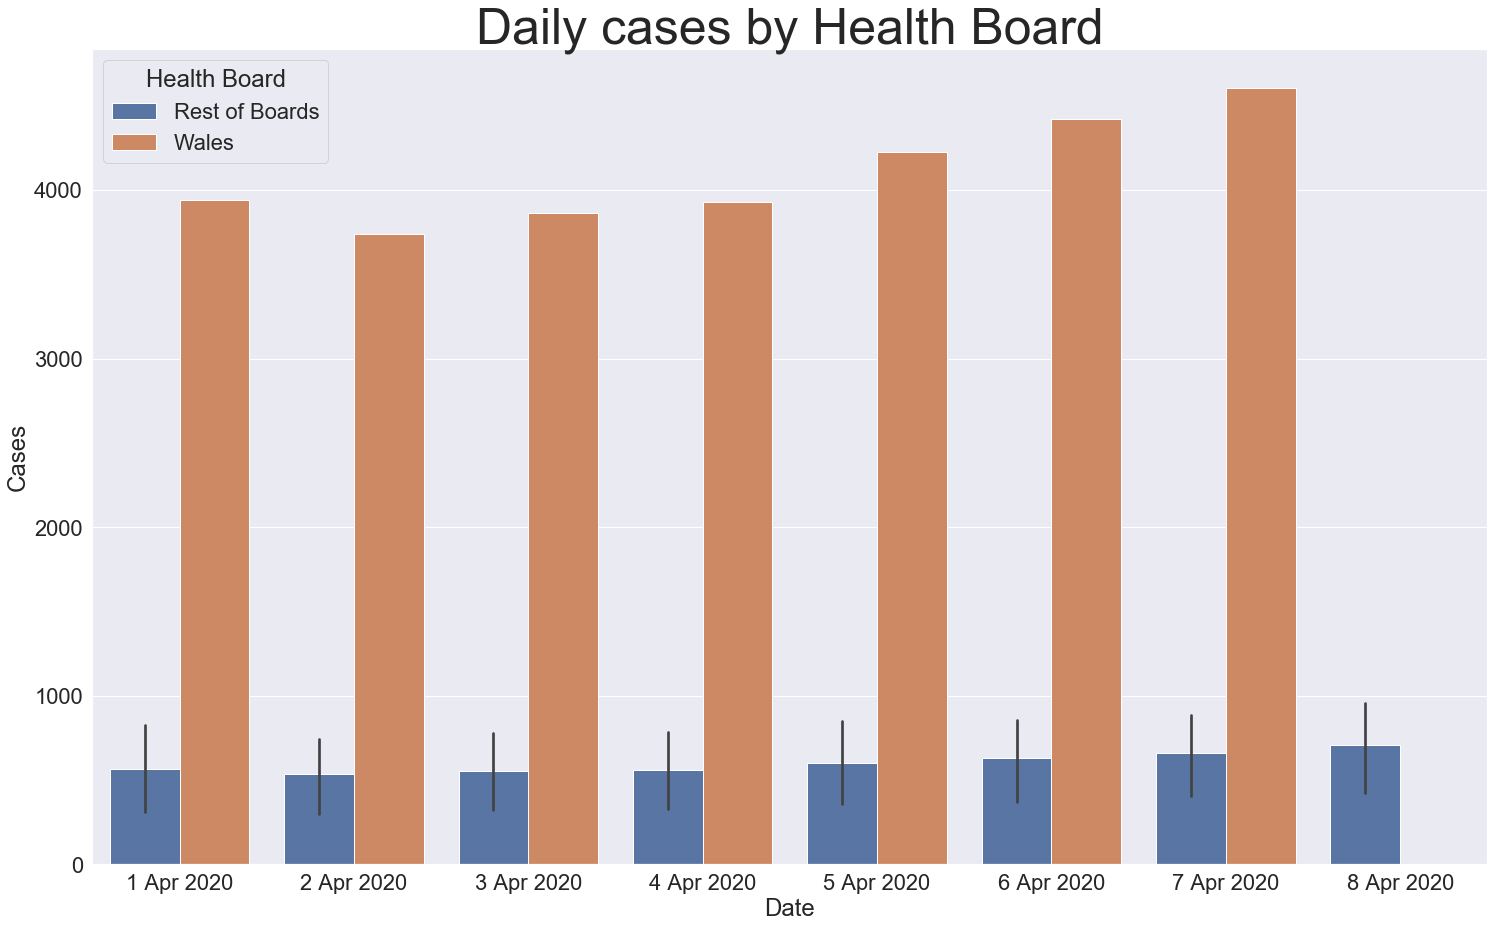

In [307]:
# Create figure and axes (no need to use the previous syntax, as the y-label ticks aren't going to be formatted)
plt.figure(figsize=(25, 15))

# Add a title

plt.title('Daily cases by Health Board', fontdict = {'fontsize' : 50})

# Use Seaborn to create the bar plot

barplot = sns.barplot(data=df_covid_date, x="Date_ItemName_ENG", y="Data", hue = 'binary_board')

barplot.legend(title="Health Board")
barplot.set(xlabel='Date', ylabel='Cases')


plt.show()